# Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, precision_score, f1_score
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE, mutual_info_classif as MIC

# Importing the dataset

In [2]:
dataset = pd.read_csv('bank-additional-full.csv', sep=';', quotechar='"')

In [3]:
dataset_copy = dataset.copy()

In [4]:
dataset.shape

(41188, 21)

#### Reordering the columns order as numerical to categorical

In [5]:
def change_column_type_object_to_categorical(df):
    object_columns = df.select_dtypes(include=['object']).columns.tolist()
    for column in object_columns:
        df[column] = pd.Categorical(df[column])

In [6]:
change_column_type_object_to_categorical(dataset_copy)

In [7]:
# Separate numerical and categorical columns
numerical_columns = dataset_copy.select_dtypes(include='number').columns.tolist()
categorical_columns = dataset_copy.select_dtypes(exclude='number').columns.tolist()

# Reorder the dataset as starting with numerical columns then categorical
new_order = numerical_columns + categorical_columns
dataset_copy = dataset_copy[new_order]

In [8]:
dataset_copy.dtypes

age                  int64
duration             int64
campaign             int64
pdays                int64
previous             int64
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
poutcome          category
y                 category
dtype: object

## Defining required functions:

In [9]:
def visualize_features(df,column_name):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column_name, kde=True, color='skyblue')
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [10]:
def visualize_target_feature(df,column_name):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column_name, hue='y', multiple='stack', palette='Set2')
    plt.title(f"Distribution of 'y' within {column_name} Groups")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [11]:
def visualize_outliers(df, column_name):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=column_name, color='skyblue')
    plt.title(f"Boxplot of {column_name} (with Outliers)")
    plt.xlabel(column_name)
    plt.tight_layout()
    plt.show()

In [12]:
def visualize(df,column_name):
    visualize_features(df,column_name)
    visualize_target_feature(df,column_name)
    visualize_outliers(df, column_name)

In [13]:
def remove_outliers_by_quantiles(df, column_name, lower_quantile=0.05, upper_quantile=0.95):
    lower_bound = df[column_name].quantile(lower_quantile)
    upper_bound = df[column_name].quantile(upper_quantile)
    df.drop(df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index, inplace=True)

In [14]:
def extract_feature_by_thresholds(df,col_name,thresholds):
    labels = []
    for i in range(len(thresholds) - 1):
        label = f"{col_name}_({thresholds[i]}_{thresholds[i+1]}]"
        mask = (df[col_name] > thresholds[i]) & (df[col_name] <= thresholds[i+1])
        df.loc[mask, f'{col_name}_group'] = label
        labels.append(label)

In [15]:
def print_extract_feature_by_thresholds(df,col_name,thresholds):
    percentages = {}
    total_samples = len(df)
    for i in range(len(thresholds) - 1):
        lower_bound = thresholds[i]
        upper_bound = thresholds[i + 1]
        mask = (df[col_name] > lower_bound) & (df[col_name] <= upper_bound)
        count = df.loc[mask].shape[0]
        percentage = (count / total_samples)
        rounded_percentage = round(percentage, 4)
        print(f"({lower_bound}_{upper_bound}] = {rounded_percentage}, samples:{count}")

In [16]:
def calculate_success_rate(df, feature_column, target_column, lower_bound,upper_bound):
    # Filter the DataFrame for the specific condition
    filtered_df = df[(df[feature_column] >= lower_bound) & (df[feature_column] <= upper_bound)].copy()
    # Group by the feature column and calculate the rate of 'yes' for each unique value
    grouped = filtered_df.groupby(feature_column)[target_column].apply(lambda x: (x == 'yes').mean())
    success_rate = grouped.mean()
    return grouped, success_rate

In [17]:
def generate_start_end_threshold(df, col_name, increment_range):
    start = df[col_name].min() - (df[col_name].min())%increment_range
    end = df[col_name].max() - (df[col_name].max())%increment_range + increment_range
    return start, end

In [18]:
def generate_threshold(df,col_name,increment_range):
    start, end = generate_start_end_threshold(df,col_name,increment_range)
    thresholds = []
    threshold = start
    while threshold <= end:
        thresholds.append(threshold)
        threshold += increment_range
    return thresholds

In [19]:
def correlation_heatmap(df,numerical_col):
    ## taking from https://github.com/bowcai/bank-analysis/blob/main/bank-analysis.ipynb
    fig= plt.figure(figsize=(8,8))

    corr = df[numerical_col].corr()
    mask = np.triu(df[numerical_col].corr())

    axes = fig.add_axes([0, 0, 1, 1])
    sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
                linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

# Data Visualization

In [20]:
# for col in dataset_copy.columns:
#     visualize_features(dataset_copy,col)

# Handling outliers

In [21]:
numerical_columns

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [22]:
for col_name in numerical_columns:
    remove_outliers_by_quantiles(dataset_copy,col_name)

# Handling missing values

In [23]:
# Only categorical features has missing values
print(dataset_copy[categorical_columns].isin(['unknown']).sum())

job             188
marital          46
education       997
default        6314
housing         620
loan            620
contact           0
month             0
day_of_week       0
poutcome          0
y                 0
dtype: int64


In [24]:
# Replacing the "unknown" with np.nan
dataset_copy.replace('unknown', np.nan, inplace=True)
dataset_copy.fillna(dataset_copy.mode().iloc[0], inplace=True)

# Feature Extraction:

##### 1-) "Age"

In [25]:
age_threshold = generate_threshold(dataset_copy,'age',5)
print(age_threshold)

[25, 30, 35, 40, 45, 50, 55, 60]


In [26]:
print_extract_feature_by_thresholds(dataset_copy,'age',age_threshold)

(25_30] = 0.1418, samples:3772
(30_35] = 0.2413, samples:6419
(35_40] = 0.197, samples:5240
(40_45] = 0.1514, samples:4029
(45_50] = 0.1245, samples:3312
(50_55] = 0.0947, samples:2520
(55_60] = 0.0493, samples:1312


In [27]:
extract_feature_by_thresholds(dataset_copy,'age',age_threshold)

##### 2-) "duration"

In [28]:
duration_threshold = generate_threshold(dataset_copy,'duration',100)
print(duration_threshold)

[0, 100, 200, 300, 400, 500, 600, 700, 800]


In [29]:
print_extract_feature_by_thresholds(dataset_copy,'duration',duration_threshold)

(0_100] = 0.2214, samples:5890
(100_200] = 0.3457, samples:9197
(200_300] = 0.1925, samples:5122
(300_400] = 0.1074, samples:2856
(400_500] = 0.0575, samples:1529
(500_600] = 0.0381, samples:1013
(600_700] = 0.0269, samples:716
(700_800] = 0.0106, samples:281


In [30]:
extract_feature_by_thresholds(dataset_copy,'duration',duration_threshold)

##### 3-) "pdays"

In [31]:
dataset_copy['pdays_group'] = dataset_copy['pdays']
dataset_copy.loc[dataset_copy['pdays'] <= 100, 'pdays_group'] = 0
dataset_copy.loc[dataset_copy['pdays'] > 100, 'pdays_group'] = 1

In [32]:
print(dataset_copy['pdays_group'].value_counts())

pdays_group
1    26604
Name: count, dtype: int64


##### 4-) "emp.var.rate"

In [33]:
dataset_copy['emp.var.rate_sign'] = dataset_copy['emp.var.rate']
dataset_copy.loc[dataset_copy['emp.var.rate'] < 0, 'emp.var.rate_sign'] = -1    # negative employment variation rate
dataset_copy.loc[dataset_copy['emp.var.rate'] > 0, 'emp.var.rate_sign'] = 1     # positive employment variation rate

In [34]:
print(dataset_copy['emp.var.rate_sign'].value_counts())

emp.var.rate_sign
 1.0    17789
-1.0     8815
Name: count, dtype: int64


##### 5-) "cons.conf.idx"

In [35]:
cons_conf_idx_threshold = generate_threshold(dataset_copy,'cons.conf.idx',5)
print(cons_conf_idx_threshold)

[-50.0, -45.0, -40.0, -35.0]


In [36]:
print_extract_feature_by_thresholds(dataset_copy,'cons.conf.idx',cons_conf_idx_threshold)

(-50.0_-45.0] = 0.2094, samples:5571
(-45.0_-40.0] = 0.4134, samples:10997
(-40.0_-35.0] = 0.3772, samples:10036


In [37]:
extract_feature_by_thresholds(dataset_copy,'cons.conf.idx',cons_conf_idx_threshold)

# Encoding features:

In [38]:
print(categorical_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


In [39]:
label_encoded_features = ['age_group','duration_group','cons.conf.idx_group',
                          'education','default','housing','loan','month',
                          'day_of_week','poutcome','marital','contact','y']
onehot_encoded_features = ['job']

In [40]:
ohe = OneHotEncoder(dtype='int32')
label_encoder = LabelEncoder()

for col in onehot_encoded_features:
    transformed = ohe.fit_transform(dataset_copy[[col]])
    dataset_copy[ohe.categories_[0]] = transformed.toarray()

for column in label_encoded_features:
    dataset_copy[column] = label_encoder.fit_transform(dataset_copy[column])

In [41]:
dataset_copy.dtypes

age                       int64
duration                  int64
campaign                  int64
pdays                     int64
previous                  int64
emp.var.rate            float64
cons.price.idx          float64
cons.conf.idx           float64
euribor3m               float64
nr.employed             float64
job                    category
marital                   int32
education                 int32
default                   int32
housing                   int32
loan                      int32
contact                   int32
month                     int32
day_of_week               int32
poutcome                  int32
y                         int32
age_group                 int32
duration_group            int32
pdays_group               int64
emp.var.rate_sign       float64
cons.conf.idx_group       int32
admin.                    int32
blue-collar               int32
entrepreneur              int32
housemaid                 int32
management                int32
retired 

# Feature Reduction:

<Axes: >

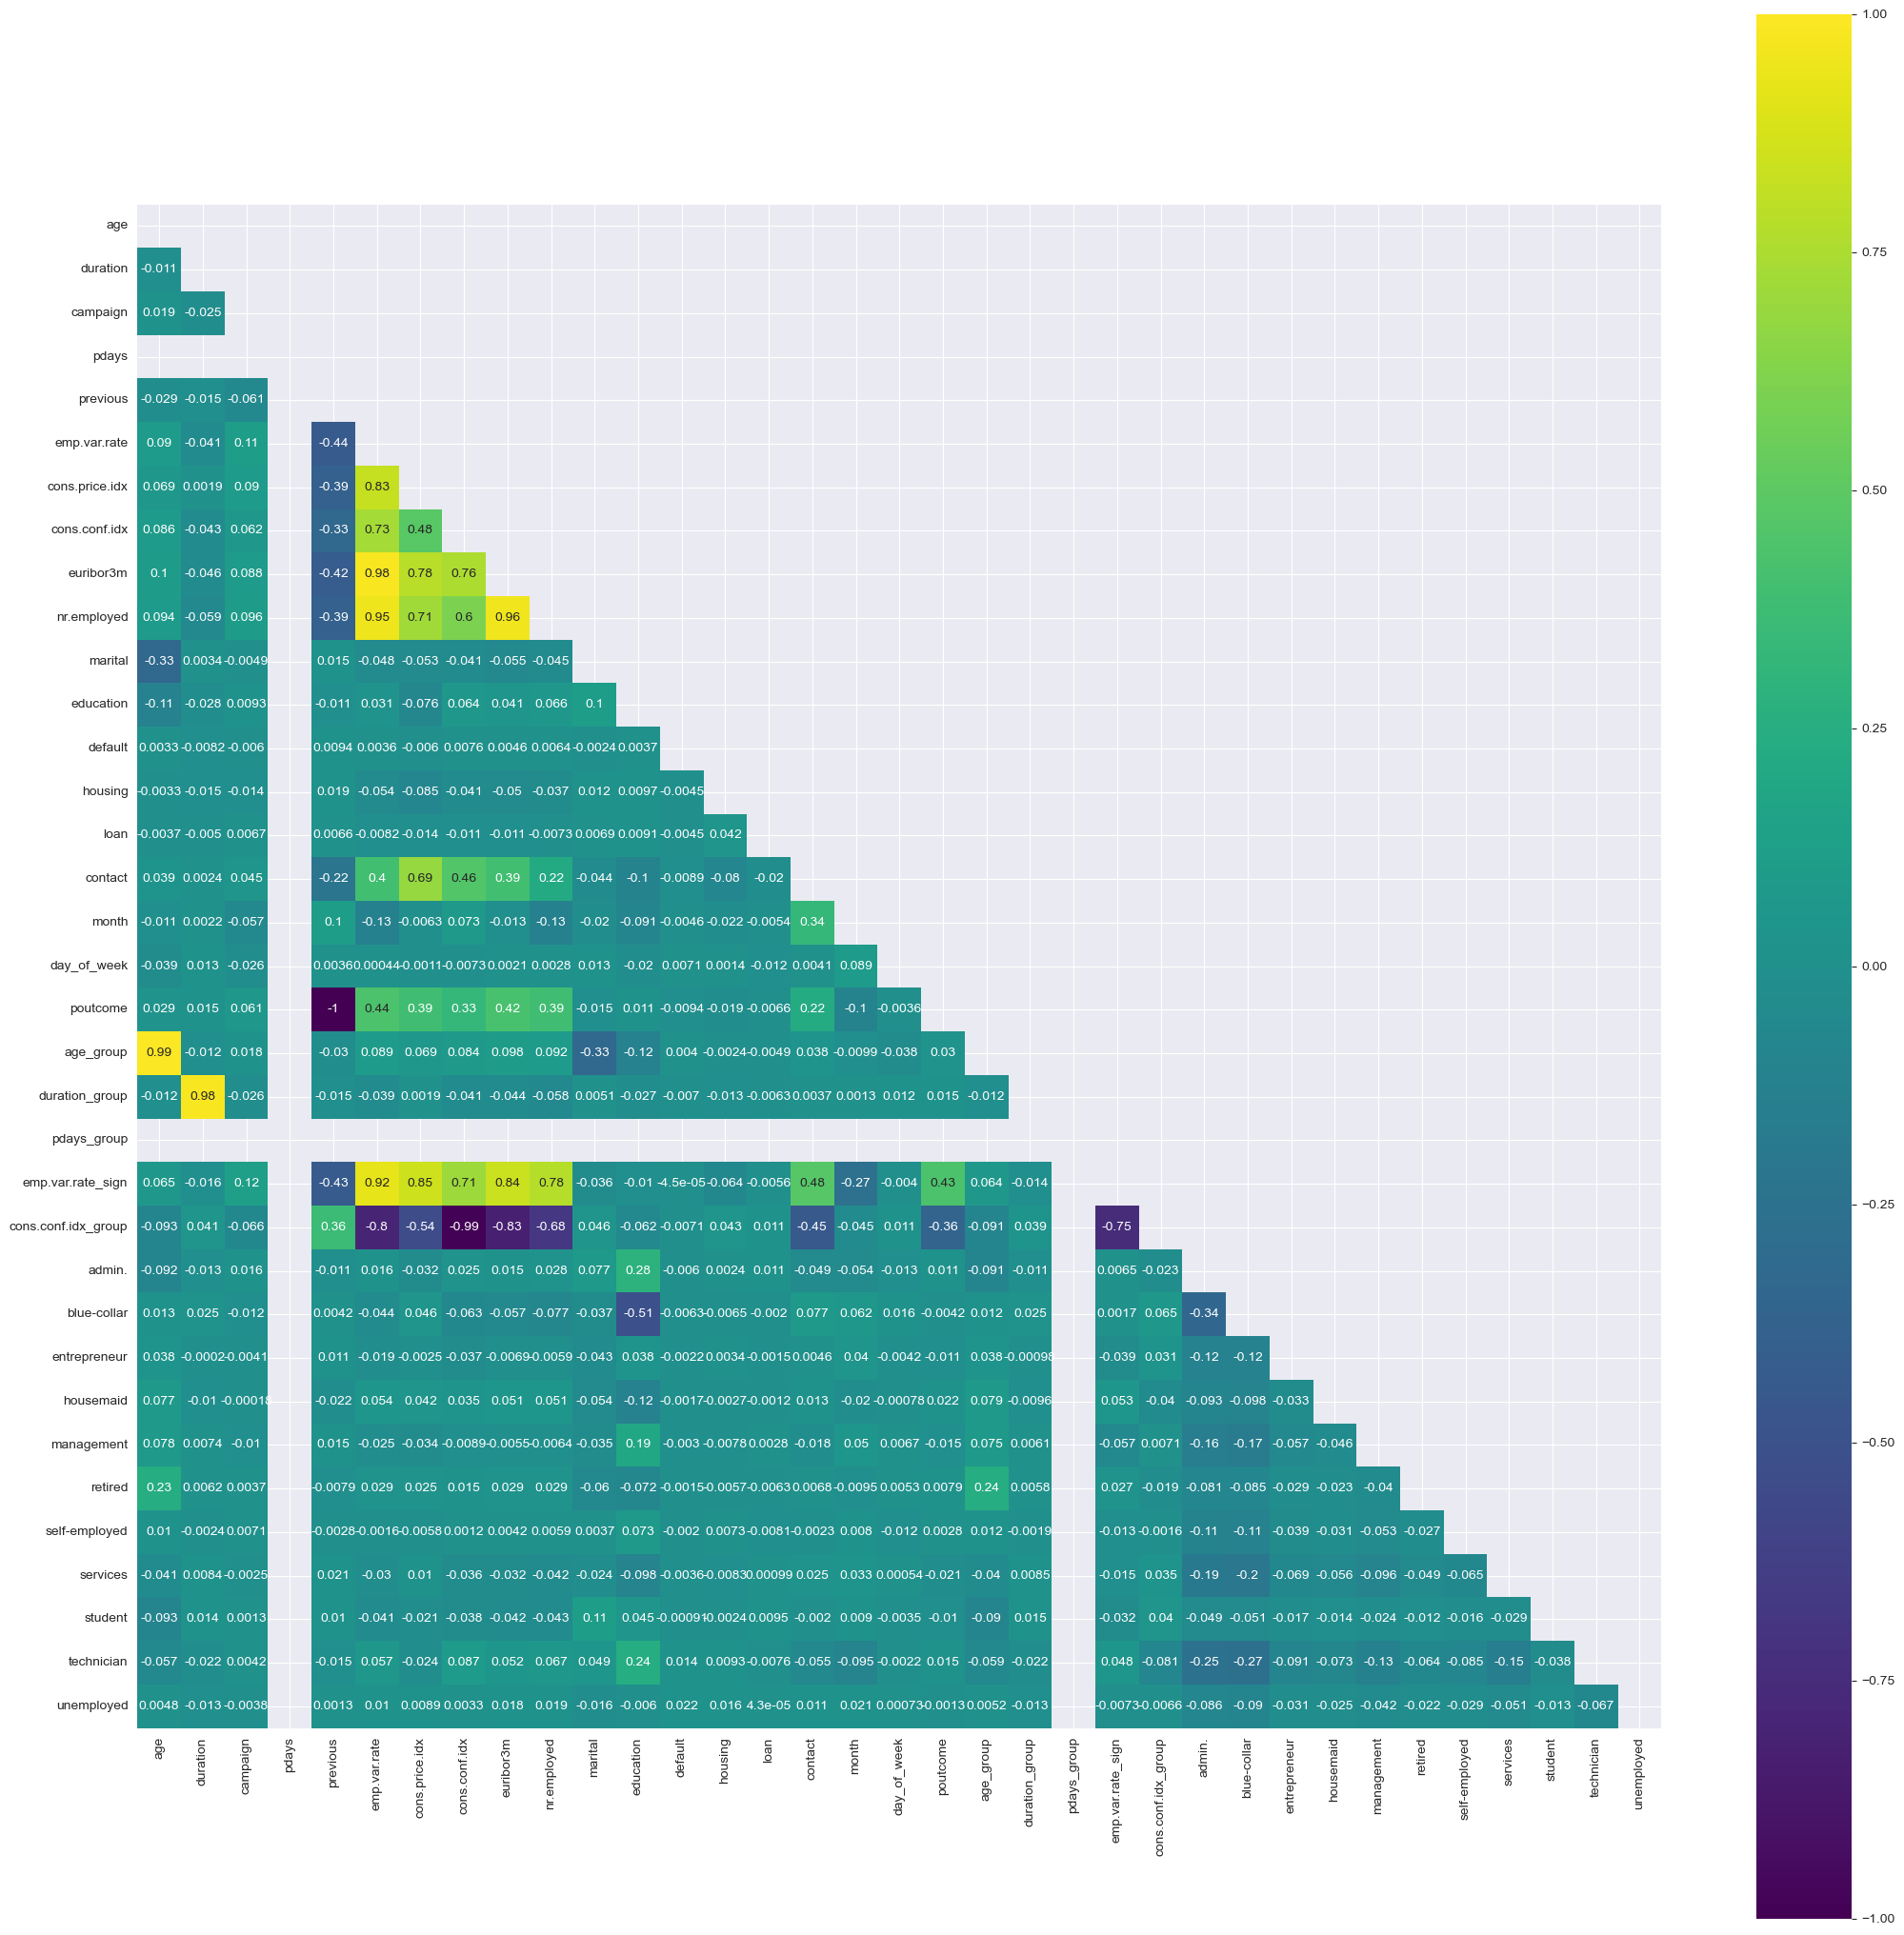

In [42]:
fig= plt.figure(figsize=(20,20))
df = dataset_copy.drop(['y','job'], axis=1)
corr = df.corr()
mask = np.triu(df.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [43]:
# selected_features = ['age_group','duration_group','campaign','previous','emp.var.rate_sign','cons.conf.idx_group',
#                      'marital','default','housing','loan','contact','month','day_of_week','admin.', 'blue-collar', 'entrepreneur',
#                      'housemaid', 'management', 'retired', 'self-employed', 'services',
#                      'student', 'technician', 'unemployed','y']
# dataset_selected = dataset_copy[selected_features].copy()

In [44]:
# Remove the one of the high correlated features
dataset_selected= dataset_copy.drop(['age','duration','pdays','cons.price.idx','job','poutcome','emp.var.rate','cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)
numerical_columns = dataset_selected.select_dtypes(include='number').columns.tolist()

<Axes: >

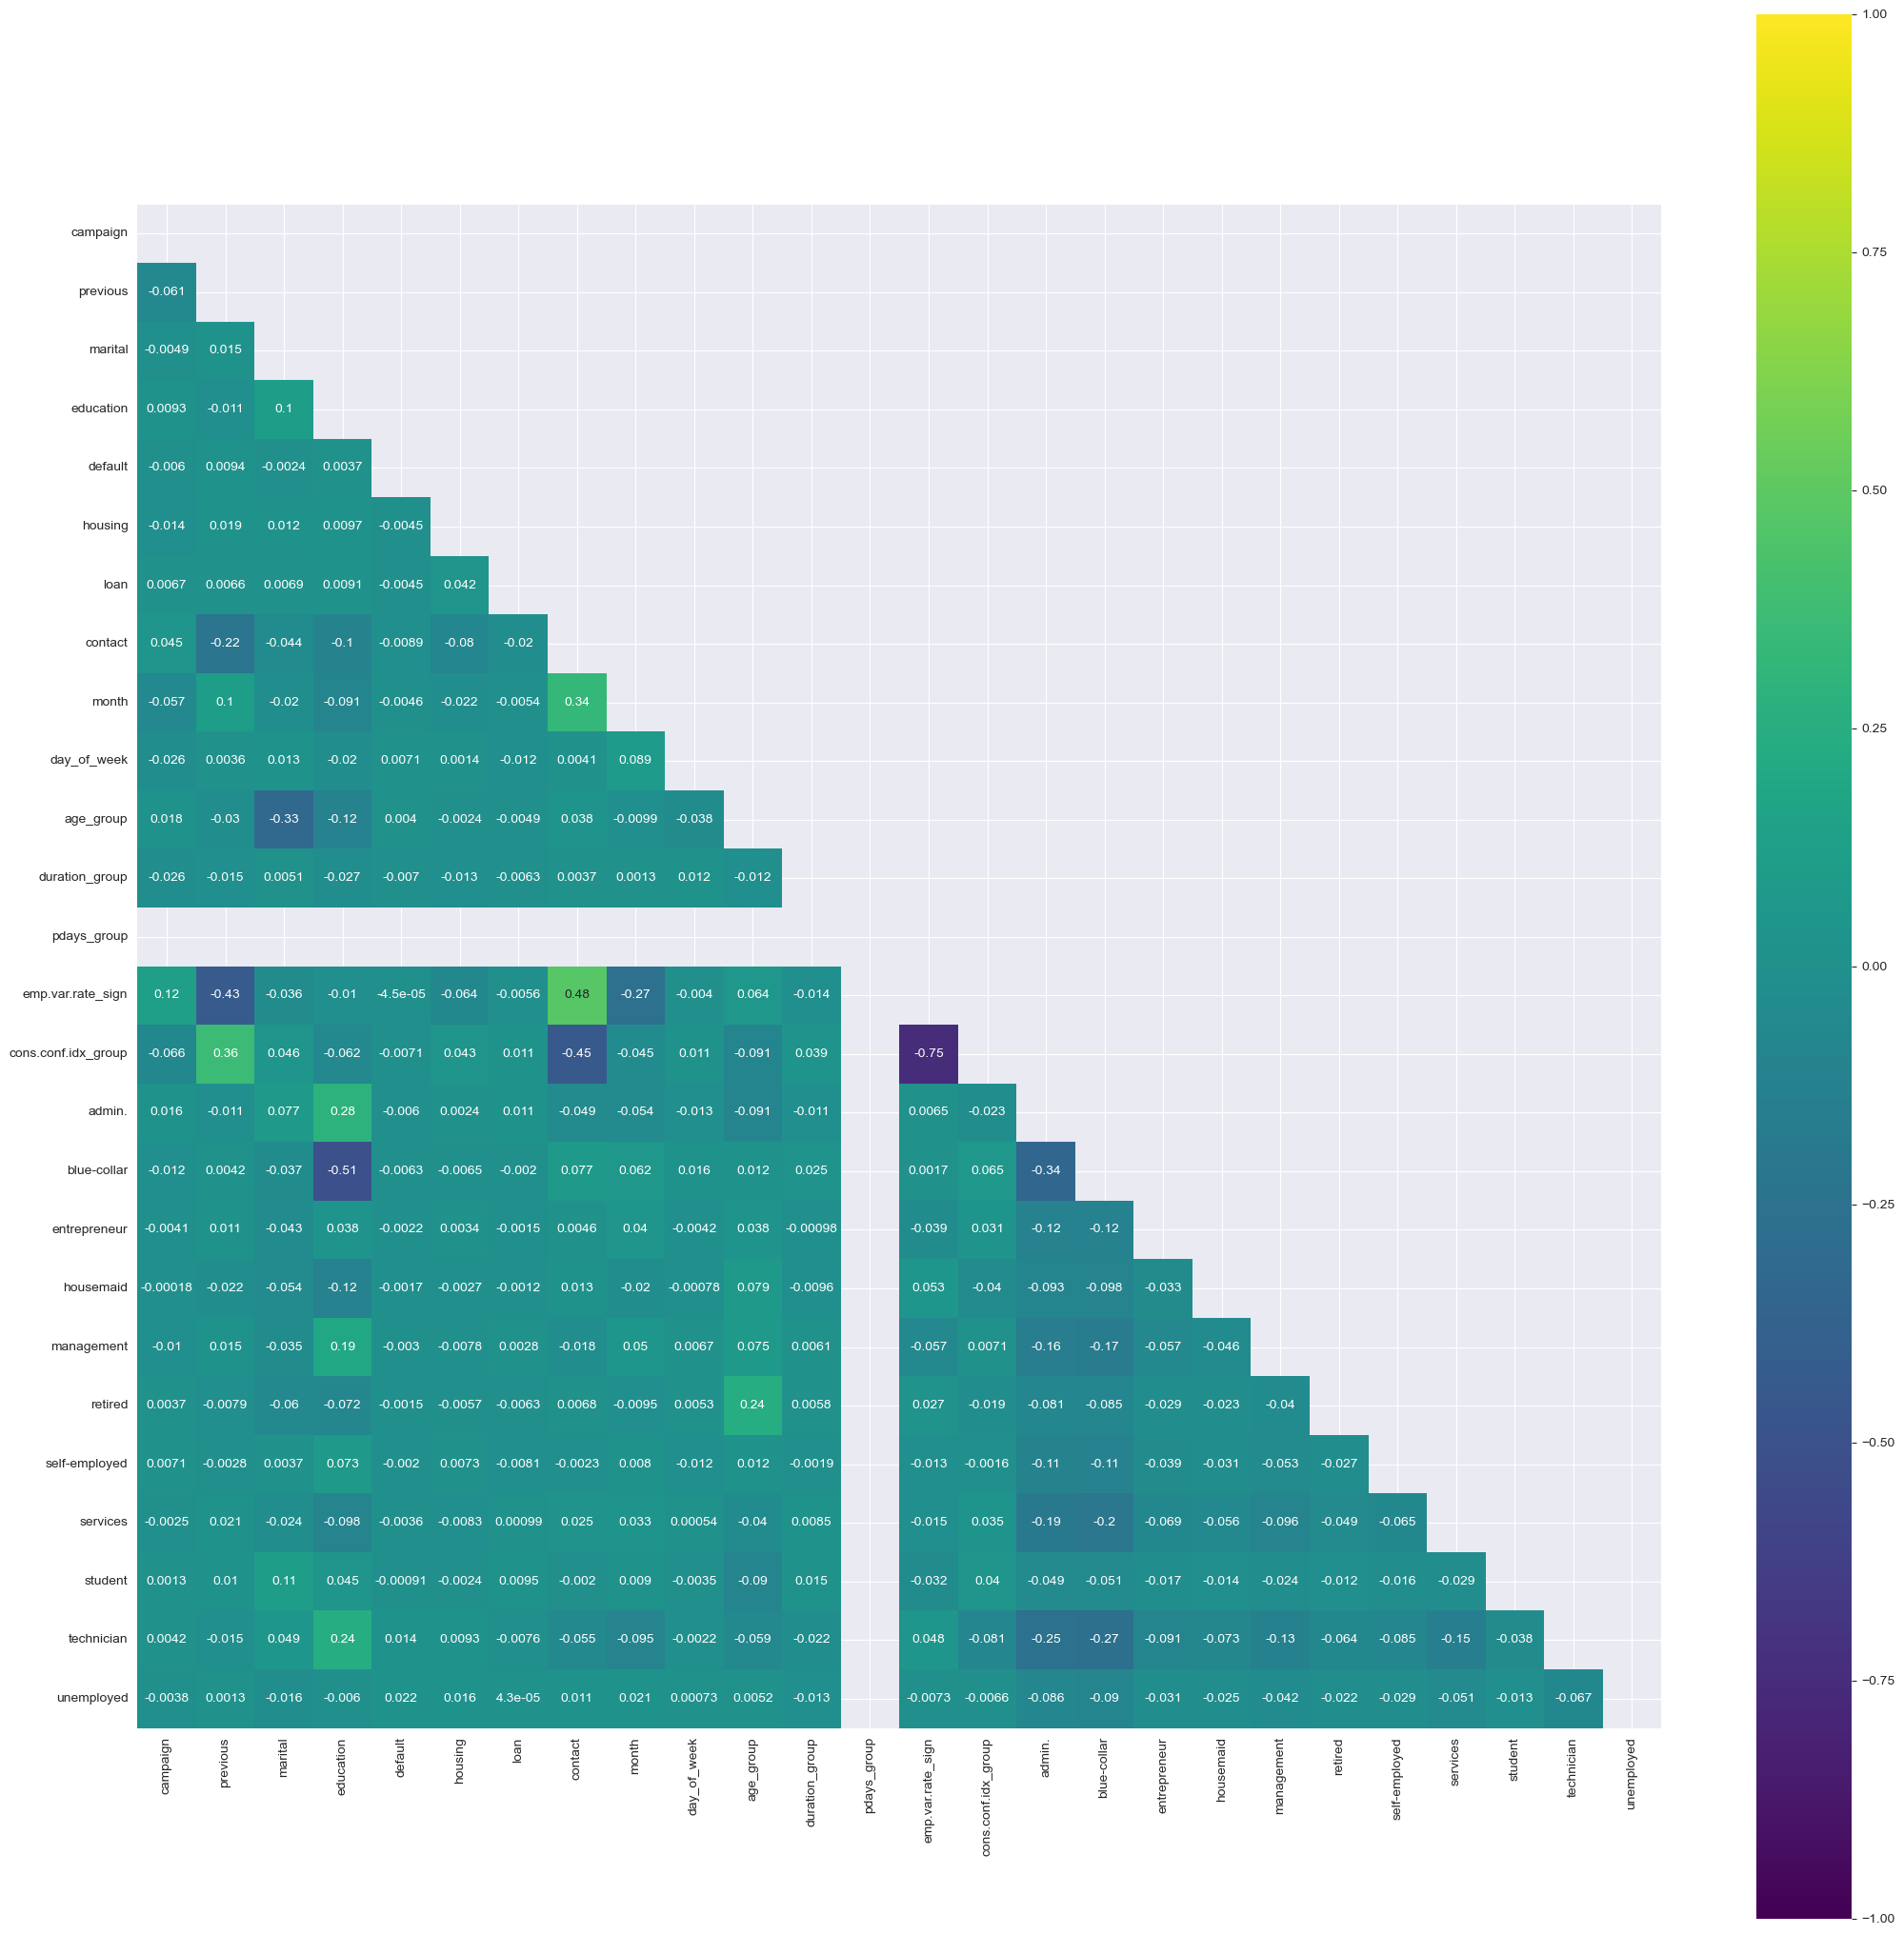

In [45]:
fig= plt.figure(figsize=(20,20))
df = dataset_selected.drop(['y'], axis=1)
corr = df.corr()
mask = np.triu(df.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [46]:
dataset_selected.columns

Index(['campaign', 'previous', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'y', 'age_group',
       'duration_group', 'pdays_group', 'emp.var.rate_sign',
       'cons.conf.idx_group', 'admin.', 'blue-collar', 'entrepreneur',
       'housemaid', 'management', 'retired', 'self-employed', 'services',
       'student', 'technician', 'unemployed'],
      dtype='object')

In [47]:
dataset_selected.dtypes

campaign                 int64
previous                 int64
marital                  int32
education                int32
default                  int32
housing                  int32
loan                     int32
contact                  int32
month                    int32
day_of_week              int32
y                        int32
age_group                int32
duration_group           int32
pdays_group              int64
emp.var.rate_sign      float64
cons.conf.idx_group      int32
admin.                   int32
blue-collar              int32
entrepreneur             int32
housemaid                int32
management               int32
retired                  int32
self-employed            int32
services                 int32
student                  int32
technician               int32
unemployed               int32
dtype: object

# Feature Sampling:

In [48]:
dataset_copy.shape

(26604, 37)

In [49]:
X = dataset_selected.drop(['y'], axis=1)
y = dataset_selected['y']

In [50]:
X.head()

,campaign,previous,marital,education,default,housing,loan,contact,month,day_of_week,...,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
0,1,0,1,0,0,0,0,1,4,1,...,0,0,1,0,0,0,0,0,0,0
1,1,0,1,3,0,0,0,1,4,1,...,0,0,0,0,0,0,1,0,0,0
2,1,0,1,3,0,1,0,1,4,1,...,0,0,0,0,0,0,1,0,0,0
3,1,0,1,1,0,0,0,1,4,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,3,0,0,1,1,4,1,...,0,0,0,0,0,0,1,0,0,0


In [51]:
counter = Counter(y)
print(f"Before oversampling:{counter}")

oversampling = SMOTE()
X_oversampled, y_smote_sampler = oversampling.fit_resample(X, y)

counter = Counter(y_smote_sampler)
print(f"After oversampling:{counter}")

Before oversampling:Counter({0: 25653, 1: 951})
After oversampling:Counter({0: 25653, 1: 25653})


# Feature Transformation

In [52]:
# Apply Min_Max scaler
scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()

X_minmax = scaler_minmax.fit_transform(X_oversampled)
X_standard = scaler_standard.fit_transform(X_oversampled)

# Feature Selection:

In [53]:
# Prepare dataset for RFE (Recursive Feature Elimination)
def func_RFE_X_rfe(param_X,param_y):
    model = LogisticRegression(max_iter=1000)
    rfe = RFE(model, step = 4)
    fit = rfe.fit(param_X,param_y)
    selected_features = fit.support_
    X_rfe = param_X[:, selected_features]
    print("Num Features: %s" % (fit.n_features_))
    print("Selected Features: %s" % (fit.support_))
    print("Feature Ranking: %s" % (fit.ranking_))
    return X_rfe

In [54]:
# Prepare dataset for SelectKBest (score_func=chi2)
def func_SelectKBest_X_chi2(param_X,param_y):
    test = SelectKBest(score_func=chi2, k=23)
    fit = test.fit(param_X,param_y)
    X_chi2 = fit.transform(param_X)
    return X_chi2

In [55]:
# Prepare dataset for Ridge
def func_Ridge_X_ridge(param_X,param_y):
    ridge = Ridge(alpha=1.0)
    ridge.fit(param_X,param_y)
    best_alpha = ridge.alpha
    ridge_model = Ridge(alpha=best_alpha)
    ridge_model.fit(param_X,param_y)
    selector = SelectFromModel(ridge_model)
    X_ridge = selector.transform(param_X)
    return X_ridge

In [56]:
# Prepare dataset for MIC (mutual_info_classification)
def func_MIC_X_mic(param_X,param_y):
    mi_scores = MIC(param_X,param_y)
    mi_score_selected_index = np.where(mi_scores <0.2)[0]
    X_mic = param_X[:,mi_score_selected_index]
    return X_mic

In [57]:
def print_scores(accuracy_score, recall_score, precision_score, f1_score, model_name):
    print(f"accuracy_{model_name}:{accuracy_score:10.4f}\t"
          f"recall {model_name}:{recall_score:10.4f}\t"
          f"precision {model_name}:{precision_score:10.4f}\t"
          f"f1_score_{model_name}:{f1_score:10.4f}")

In [58]:
def predict_scores(model, x_test, y_test):
    score           = model.score(x_test,y_test)
    y_predict       = model.predict(x_test)
    score_recall    = recall_score(y_test,y_predict)
    score_precision = precision_score(y_test,y_predict)
    f1_scr          = f1_score(y_test, y_predict)
    return score,score_recall,score_precision, f1_scr

In [59]:
def func_Calculate_Model_Scores(param_x,param_y, X_chi2, X_rfe, X_ridge, X_mic):
    # Split the data into training and testing sets
    
    X_train, X_test, y_train, y_test                     = train_test_split(param_x,param_y, random_state=0, stratify=param_y)
    X_train_chi2, X_test_chi2, y_train_chi2, y_test_chi2 = train_test_split(X_chi2, param_y, random_state=0, stratify=param_y)
    X_train_RFE, X_test_RFE, y_train_RFE, y_test_RFE     = train_test_split(X_rfe, param_y, random_state=0, stratify=param_y)
    X_train_Ridge, X_test_Ridge, y_train_Ridge, y_test_Ridge = train_test_split(X_ridge, param_y, random_state=0, stratify=param_y)
    X_train_MIC, X_test_MIC, y_train_MIC, y_test_MIC     = train_test_split(X_mic, param_y, random_state=0, stratify=param_y)
    RFC = RandomForestClassifier()

    # Compare results with Random Forest Classifier
    model_default = RFC.fit(X_train,y_train)
    score_default, recall_score_default, precision_score_default, f1_score_default = predict_scores(model_default,X_test,y_test) 

    model_MIC = RFC.fit(X_train_MIC,y_train_MIC)
    score_MIC, recall_score_MIC, precision_score_MIC, f1_score_MIC = predict_scores(model_MIC,X_test_MIC,y_test_MIC)

    model_chi2 = RFC.fit(X_train_chi2,y_train_chi2)
    score_chi2, recall_score_chi2, precision_score_chi2, f1_score_chi2 = predict_scores(model_chi2,X_test_chi2,y_test_chi2)

    model_RFE = RFC.fit(X_train_RFE,y_train_RFE)
    score_rfe, recall_score_rfe, precision_score_rfe, f1_score_rfe = predict_scores(model_RFE,X_test_RFE,y_test_RFE)

    model_Ridge = RFC.fit(X_train_Ridge,y_train_Ridge)
    score_ridge, recall_score_ridge, precision_score_ridge, f1_score_ridge = predict_scores(model_Ridge,X_test_Ridge,y_test_Ridge)

    #---------------------------------------------------------------------------------
    print_scores(score_MIC, recall_score_MIC, precision_score_MIC, f1_score_MIC, "MIC")
    print_scores(score_rfe, recall_score_rfe, precision_score_rfe, f1_score_rfe, "RFE")
    print_scores(score_chi2, recall_score_chi2, precision_score_chi2, f1_score_chi2, "chi2")
    print_scores(score_ridge, recall_score_ridge, precision_score_ridge, f1_score_ridge, "Ridge")
    print_scores(score_default, recall_score_default, precision_score_default, f1_score_default, "default")

In [60]:
print("Scores for minmax scaler:")
x_chi2 = func_SelectKBest_X_chi2(X_minmax,y_smote_sampler)
x_rfe = func_Ridge_X_ridge(X_minmax,y_smote_sampler)
x_ridge = func_Ridge_X_ridge(X_minmax,y_smote_sampler)
x_mic = func_MIC_X_mic(X_minmax,y_smote_sampler)

func_Calculate_Model_Scores(X_minmax, y_smote_sampler, x_chi2, x_rfe, x_ridge, x_mic)

Scores for minmax scaler:
accuracy_MIC:    0.9598	recall MIC:    0.9716	precision MIC:    0.9491	f1_score_MIC:    0.9602
accuracy_RFE:    0.9143	recall RFE:    0.9308	precision RFE:    0.9011	f1_score_RFE:    0.9157
accuracy_chi2:    0.9742	recall chi2:    0.9850	precision chi2:    0.9641	f1_score_chi2:    0.9745
accuracy_Ridge:    0.9137	recall Ridge:    0.9317	precision Ridge:    0.8993	f1_score_Ridge:    0.9152
accuracy_default:    0.9782	recall default:    0.9889	precision default:    0.9682	f1_score_default:    0.9785


# Cross-Validation

In [61]:
# from sklearn.model_selection import cross_val_score
# from sklearn.svm import SVC
# X_train, X_test, y_train, y_test   = train_test_split(X_minmax,y_smote_sampler, random_state=0, stratify=y_smote_sampler)
# 
# model = SVC(kernel= 'rbf', random_state=0)
# model.fit(X_train,y_train)
# accuracy = cross_val_score(estimator= model, X=X_train, y = y_train, cv=10)

In [62]:
# from sklearn.model_selection import GridSearchCV
# 
# parameters = [{'C': [0.5,1,10], 'kernel': ['linear']},
#               {'C': [0.5,1,10], 'kernel': ['rbf'], 'gamma': [0.1, 0.5, 1]}]
# grid_search = GridSearchCV(estimator= model,
#                            param_grid= parameters,
#                            scoring= 'accuracy',
#                            cv = 10,
#                            n_jobs= -1)
# grid_search.fit(X_train,y_train)
# best_accuracy = grid_search.best_score_
# best_parameters = grid_search.best_params_

In [63]:
# print("Best accuracy:{:.2f}".format(best_accuracy*100))
# print("Best parameters:",best_parameters)

# Splitting the dataset into the Training set and Test set

In [64]:
X_train, X_test, y_train, y_test   = train_test_split(X_oversampled,y_smote_sampler, random_state=42)

# Feature Scaling

In [65]:
sc = StandardScaler()
X_train_ml = sc.fit_transform(X_train)
X_test_ml = sc.transform(X_test)

# ML Algorithms Implementation:

In [66]:
def plot_confusion_matrix(X_test, y_test, model, model_name):
    # Generate confusion matrix
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Create a custom colormap for better readability
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Create a heatmap with customized colors and annotations
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap=cmap, fmt='g', cbar=False)

    # Set labels, title, and layout
    plt.title(f'Confusion Matrix of {model_name}', fontsize=16)
    plt.xlabel('Predicted', fontsize=8)
    plt.ylabel('Actual', fontsize=8)
    plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
    plt.tight_layout()

    plt.show()

In [67]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def draw_AUC_graph(train_X, test_X, train_y, test_y, model, model_name):
    # Get predicted probabilities for the positive class for both train and test sets
    y_train_probs = model.predict_proba(train_X)[:, 1]
    y_test_probs = model.predict_proba(test_X)[:, 1]

    # Compute ROC curve and ROC AUC for both train and test sets
    fpr_train, tpr_train, _ = roc_curve(train_y, y_train_probs)
    fpr_test, tpr_test, _ = roc_curve(test_y, y_test_probs)

    roc_auc_train = roc_auc_score(train_y, y_train_probs)
    roc_auc_test = roc_auc_score(test_y, y_test_probs)

    # Plot ROC curves for both train and test sets, display AUC values as labels
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
    plt.legend()
    plt.show()

    print(f"Train AUC: {roc_auc_train:.4f}")
    print(f"Test AUC: {roc_auc_test:.4f}")

# Training the Classification models on the Training set

In [68]:
def ml_algorithms_without_hyper_tuning(X_train,y_train):

    # Initialize individual classifiers
    dtc = DecisionTreeClassifier()
    knn = KNeighborsClassifier()
    svc = SVC(probability=True)
    logistic = LogisticRegression(max_iter=1000)
    rfc = RandomForestClassifier()
    svm = SVC(probability=True)
    gb = GradientBoostingClassifier()

    # Fit individual classifiers
    dtc.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    svc.fit(X_train, y_train)
    logistic.fit(X_train, y_train)
    rfc.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    gb.fit(X_train, y_train)
    
    return dtc, knn, svc, logistic, rfc, svm, gb

# Ensemble Models

In [69]:
def ensemble_models(X_train,y_train,estimators):
    
    voting = VotingClassifier(estimators=estimators)
    #stacking = StackingClassifier(estimators=estimators)

    voting.fit(X_train,y_train)
    #stacking.fit(X_train,y_train)
    
    return  voting

In [ ]:
model_dtc, model_knn, model_svc, model_lr, model_rfc, model_svm, model_gb= ml_algorithms_without_hyper_tuning(X_train=X_train,y_train=y_train)

In [71]:
estimators = [('dtc',model_dtc),('knn',model_knn),('svc',model_svc),('logistic',model_lr),('rfc',model_rfc),('svm',model_svm), ('gb', model_gb)]

In [72]:
model_voting = VotingClassifier(estimators=estimators)
model_voting.fit(X_train,y_train)

C:\Users\batuh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('dtc', DecisionTreeClassifier()),
                             ('knn', KNeighborsClassifier()),
                             ('svc', SVC(probability=True)),
                             ('logistic', LogisticRegression()),
                             ('rfc', RandomForestClassifier()),
                             ('svm', SVC(probability=True)),
                             ('gb', GradientBoostingClassifier())])

In [73]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# Visualizing the ROC curve with AUC values

In [153]:
# for model,model_name in zip(models,model_names):
#     draw_AUC_graph(X_train,X_test,y_train,y_test,model,model_name)

# Visualizing the Confusion Matrix

In [154]:
# for model,model_name in zip(models,model_names):
#     print(f"{model}, {model_name}")
#     plot_confusion_matrix(X_test=X_test, y_test=y_test, model=model, model_name=model_name)

# Printing the accuracy,recall,precision,f1 scores for ml models:

In [74]:
score_dtc, recall_score_dtc, precision_score_dtc, f1_score_dtc = predict_scores(model_dtc,X_test,y_test)
score_knn, recall_score_knn, precision_score_knn, f1_score_knn = predict_scores(model_knn,X_test,y_test)
score_svc, recall_score_svc, precision_score_svc, f1_score_svc = predict_scores(model_svc,X_test,y_test)
score_lr, recall_score_lr, precision_score_lr, f1_score_lr     = predict_scores(model_lr,X_test,y_test)
score_rfc, recall_score_rfc, precision_score_rfc, f1_score_rfc = predict_scores(model_rfc,X_test,y_test)
score_svm, recall_score_svm, precision_score_svm, f1_score_svm = predict_scores(model_svm,X_test,y_test)
score_gb, recall_score_gb, precision_score_gb, f1_score_gb = predict_scores(model_gb,X_test,y_test)

In [75]:
print_scores(score_dtc, recall_score_dtc, precision_score_dtc, f1_score_dtc, "DTC")
print_scores(score_knn, recall_score_knn, precision_score_knn, f1_score_knn, "KNN")
print_scores(score_svc, recall_score_svc, precision_score_svc, f1_score_svc, "SVC")
print_scores(score_lr, recall_score_lr, precision_score_lr, f1_score_lr, "Logistic") # logistic_regression
print_scores(score_rfc, recall_score_rfc, precision_score_rfc, f1_score_rfc, "RFC")
print_scores(score_svm, recall_score_svm, precision_score_svm, f1_score_svm, "SVM")
print_scores(score_gb, recall_score_gb, precision_score_gb, f1_score_gb, "GB")

accuracy_DTC:    0.9656	recall DTC:    0.9812	precision DTC:    0.9517	f1_score_DTC:    0.9662
accuracy_KNN:    0.9323	recall KNN:    0.9969	precision KNN:    0.8831	f1_score_KNN:    0.9365
accuracy_SVC:    0.9319	recall SVC:    0.9559	precision SVC:    0.9126	f1_score_SVC:    0.9337
accuracy_Logistic:    0.9128	recall Logistic:    0.9106	precision Logistic:    0.9150	f1_score_Logistic:    0.9128
accuracy_RFC:    0.9774	recall RFC:    0.9880	precision RFC:    0.9676	f1_score_RFC:    0.9777
accuracy_SVM:    0.9319	recall SVM:    0.9559	precision SVM:    0.9126	f1_score_SVM:    0.9337
accuracy_GB:    0.9118	recall GB:    0.9377	precision GB:    0.8920	f1_score_GB:    0.9143


# Printing the accuracy,recall,precision,f1 scores for ensemble models:

In [76]:
score_voting, recall_score_voting, precision_score_voting, f1_score_voting = predict_scores(model_voting,X_test,y_test)
score_xgb, recall_score_xgb, precision_score_xgb, f1_score_xgb = predict_scores(model_xgb,X_test,y_test)
# score_stacking, recall_score_stacking, precision_score_stacking, f1_score_stacking = predict_scores(model_stacking,X_test,y_test)

In [77]:
print_scores(score_voting, recall_score_voting, precision_score_voting, f1_score_voting, "Voting")
print_scores(score_xgb, recall_score_xgb, precision_score_xgb, f1_score_xgb, "XGB")
# print_scores(score_stacking, recall_score_stacking, precision_score_stacking, f1_score_stacking, "Stacking")

accuracy_Voting:    0.9432	recall Voting:    0.9686	precision Voting:    0.9220	f1_score_Voting:    0.9447
accuracy_XGB:    0.9623	recall XGB:    0.9792	precision XGB:    0.9475	f1_score_XGB:    0.9631


# Hyper Parameter Tuning

In [75]:
# def ml_algorithms_hyper_tuning(X_train,y_train):
#     # Training the Decision Tree Classification model:
#     model_dtc = DecisionTreeClassifier(criterion='entropy', random_state=42)
#     model_dtc.fit(X_train, y_train)
# 
#     # Training the K-NN model:
#     model_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
#     model_knn.fit(X_train, y_train)
# 
#     # Training the Kernel SVM:
#     model_svc = SVC(kernel = 'rbf', random_state = 42, probability=True)
#     model_svc.fit(X_train, y_train)
# 
#     # Training the Logistic Regression model
#     model_lr = LogisticRegression(random_state = 42, max_iter=30000)
#     model_lr.fit(X_train, y_train)
# 
#     # Training the Random Forest Classification model
#     model_rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
#     model_rfc.fit(X_train, y_train)
# 
#     # Training the SVM model:
#     model_svm = SVC(kernel = 'linear', random_state = 42, probability=True)
#     model_svm.fit(X_train, y_train)    

In [76]:
# model_dtc_hp, model_knn_hp, model_svc_hp, model_lr_hp, model_rfc_hp, model_svm_hp = ml_algorithms_without_hyper_tuning(X_train=X_train,y_train=y_train)

In [77]:
# models = [model_dtc_hp, model_knn_hp, model_svc_hp, model_lr_hp, model_rfc_hp, model_svm_hp]
# model_names = ["Decision Tree","KNN","SVC","Logistic_regression","Random Forest","SVM"]

# DTC

In [78]:
model_dtc = DecisionTreeClassifier(criterion='entropy', random_state=42)
model_dtc.fit(X_train, y_train)

score_dtc, recall_score_dtc, precision_score_dtc, f1_score_dtc = predict_scores(model_dtc,X_test,y_test)
print_scores(score_dtc, recall_score_dtc, precision_score_dtc, f1_score_dtc, "DTC")

accuracy_DTC:    0.9605	recall DTC:    0.9805	precision DTC:    0.9427	f1_score_DTC:    0.9613


# KNN

In [79]:
# # Training the K-NN model:
# model_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
# model_knn.fit(X_train, y_train)
# 
# score_knn, recall_score_knn, precision_score_knn, f1_score_knn = predict_scores(model_knn,X_test,y_test)
# print_scores(score_knn, recall_score_knn, precision_score_knn, f1_score_knn, "KNN")

accuracy_KNN:    0.9249	recall KNN:    0.9971	precision KNN:    0.8712	f1_score_KNN:    0.9299


# SVC

In [80]:
# # Training the Kernel SVM:
# model_svc = SVC(kernel = 'rbf', random_state = 42, probability=True)
# model_svc.fit(X_train, y_train)
# 
# score_svc, recall_score_svc, precision_score_svc, f1_score_svc = predict_scores(model_svc,X_test,y_test)
# print_scores(score_svc, recall_score_svc, precision_score_svc, f1_score_svc, "SVC")

accuracy_SVC:    0.9279	recall SVC:    0.9573	precision SVC:    0.9041	f1_score_SVC:    0.9299


# Linear Reg

In [81]:
# # Training the Logistic Regression model
# model_lr = LogisticRegression(random_state = 42, max_iter=30000)
# model_lr.fit(X_train, y_train)
# 
# score_lr, recall_score_lr, precision_score_lr, f1_score_lr     = predict_scores(model_lr,X_test,y_test)
# print_scores(score_lr, recall_score_lr, precision_score_lr, f1_score_lr, "LRe") # logistic_regression

accuracy_LRe:    0.9090	recall LRe:    0.9081	precision LRe:    0.9097	f1_score_LRe:    0.9089


# RFC

In [82]:
# # Training the Random Forest Classification model
# model_rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
# model_rfc.fit(X_train, y_train)
# 
# score_rfc, recall_score_rfc, precision_score_rfc, f1_score_rfc = predict_scores(model_rfc,X_test,y_test)
# print_scores(score_rfc, recall_score_rfc, precision_score_rfc, f1_score_rfc, "RFC")

accuracy_RFC:    0.9719	recall RFC:    0.9836	precision RFC:    0.9611	f1_score_RFC:    0.9722


# SVM

In [ ]:
# # Training the SVM model:
# model_svm = SVC(kernel = 'linear', random_state = 42, probability=True)
# model_svm.fit(X_train, y_train)
# 
# score_svm, recall_score_svm, precision_score_svm, f1_score_svm = predict_scores(model_svm,X_test,y_test)
# print_scores(score_svm, recall_score_svm, precision_score_svm, f1_score_svm, "SVM")